In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

print(torch.__version__)
print(torchvision.__version__)
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

torch.manual_seed(42)
transform=T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((100, 100)),
    T.ToTensor(),
    T.Normalize([0.5],[0.5])])
plane_name=['An124', 'An22', 'C17', 'C5']

2.4.1+cu121
0.19.1+cu121
cuda


In [2]:
train_set=torchvision.datasets.ImageFolder(
    root="tryout",
    transform=transform)
test_set=torchvision.datasets.ImageFolder(
    root="test",
    transform=transform)

In [3]:
#print('Length is', len(train_set))

In [4]:
#item = test_set[20]
#print('item is a pair', item)
#print(plane_name[item[1]])

In [5]:
#item[0].show()

In [6]:
batch_size=64
train_loader=torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True)
test_loader=torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,shuffle=True)

In [7]:
train_set,val_set=torch.utils.data.random_split(\
    train_set,[776,156])

In [8]:
len(train_set)

776

In [9]:
train_loader=torch.utils.data.DataLoader(
    train_set,    
    batch_size=batch_size,   
    shuffle=True)   
val_loader=torch.utils.data.DataLoader(
    val_set,    
    batch_size=batch_size,   
    shuffle=True)
test_loader=torch.utils.data.DataLoader(
    test_set,    
    batch_size=batch_size,   
    shuffle=True)

In [10]:
class EarlyStop:
    def __init__(self, patience=10):
        self.patience = patience
        self.steps = 0
        self.min_loss = float('inf')
    def stop(self, val_loss):
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            self.steps = 0
        elif val_loss >= self.min_loss:
            self.steps += 1
        if self.steps >= self.patience:
            return True
        else:
            return False
stopper=EarlyStop()

In [11]:
model=nn.Sequential(
    nn.Linear(100*100,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,4),
    nn.Dropout(p=0.20),
nn.Softmax(dim=1)).to(device)

In [12]:
lr=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
loss_fn=nn.CrossEntropyLoss()

In [13]:
def train_epoch():
    tloss=0
    for n,(imgs,labels) in enumerate(train_loader):    
        imgs=imgs.reshape(-1,100*100).to(device)
        labels=labels.reshape(-1,).to(device)
        preds=model(imgs)    
        loss=loss_fn(preds,labels)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        tloss+=loss.detach()
    return tloss/n

In [14]:
def val_epoch():
    vloss=0
    for n,(imgs,labels) in enumerate(val_loader):    
        imgs=imgs.reshape(-1,100*100).to(device)
        labels=labels.reshape(-1,).to(device)
        preds=model(imgs)    
        loss=loss_fn(preds,labels)    
        vloss+=loss.detach()
    return vloss/n

In [15]:
for i in range(1,101):    
    tloss=train_epoch()
    vloss=val_epoch()
    print(f"at epoch {i}, tloss is {tloss}, vloss is {vloss}")
    if stopper.stop(vloss)==True:             
        break  

at epoch 1, tloss is 1.3802298307418823, vloss is 1.8241698741912842
at epoch 2, tloss is 1.2697856426239014, vloss is 1.8549814224243164
at epoch 3, tloss is 1.2536178827285767, vloss is 1.7587440013885498
at epoch 4, tloss is 1.213197112083435, vloss is 1.8016806840896606
at epoch 5, tloss is 1.2416231632232666, vloss is 1.7481166124343872
at epoch 6, tloss is 1.221114993095398, vloss is 1.8247411251068115
at epoch 7, tloss is 1.2275460958480835, vloss is 1.7950409650802612
at epoch 8, tloss is 1.1590306758880615, vloss is 1.6939382553100586
at epoch 9, tloss is 1.1621122360229492, vloss is 1.7584515810012817
at epoch 10, tloss is 1.1380655765533447, vloss is 1.7419471740722656
at epoch 11, tloss is 1.1642048358917236, vloss is 1.760420799255371
at epoch 12, tloss is 1.118949294090271, vloss is 1.7238619327545166
at epoch 13, tloss is 1.1008379459381104, vloss is 1.7243355512619019
at epoch 14, tloss is 1.0949032306671143, vloss is 1.7166191339492798
at epoch 15, tloss is 1.086921095

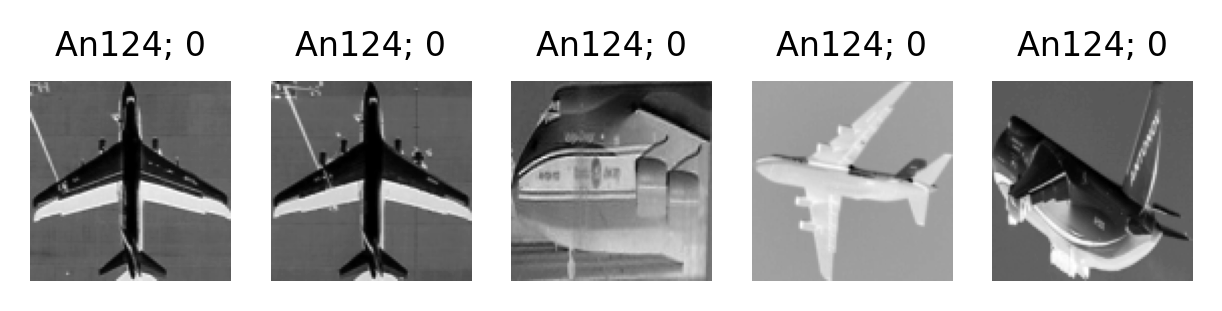

the label is An124; the prediction is C5
the label is An124; the prediction is C5
the label is An124; the prediction is C5
the label is An124; the prediction is C17
the label is An124; the prediction is C17


In [16]:
import matplotlib.pyplot as plt
plt.figure(dpi=300,figsize=(5,1))
for i in range(5):
    ax=plt.subplot(1,5, i + 1)    
    img=test_set[i][0]    
    label=test_set[i][1]
    img=img/2+0.5    
    img=img.reshape(100, 100)    
    plt.imshow(img, cmap="binary")
    plt.axis('off')
    plt.title(plane_name[label]+f"; {label}", fontsize=8)
plt.show()
for i in range(5):
    img,label = test_set[i]
    img=img.reshape(-1,100*100).to(device)
    pred=model(img)
    index_pred=torch.argmax(pred,dim=1)
    idx=index_pred.item()
    print(f"the label is {plane_name[label]}; the prediction is {plane_name[idx]}")